In [3]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity, LinearAlgebra
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false, titlefontsize=10)

# Reversible Jump

## Gaussian Mixture Model

We consider the Gaussian Mixture Model:

$$\sum_{k = 1}^{K}\pi_k\phi_k(y_i)$$

Where $K$ is unknown.

In [47]:
function get_prob(mu; tau, Y)
    pdf.(Normal(mu, 1/tau), Y)
end

function get_posterior_ll(Y, pi, mu, tau, prior_mu, prior_pi)
    K = length(mu)
    ll = sum(log.(pdf.(prior_mu, mu))) + log(pdf(prior_pi, pi))
    ll += sum(log.(pi' * transpose(reduce(hcat, get_prob.(mu, tau=tau, Y=Y))))) 
    ll
end

function draw_Z(Y; mu, pi, tau)
    K = length(pi)
    p = zeros(K)
    for i in range(1, K)
        p[i] = pdf(Normal(mu[i], 1/tau), Y) * pi[i]
    end
    p = p ./ sum(p)
    sample([1:1:K;], Weights(p))
end

function gibbs_update(Y; mu, mu0, pi, tau, tau0)
    K = length(pi)
    # draw Z1, ..., Zn
    Z = draw_Z.(Y, mu=mu, pi=pi, tau=tau)
    # draw mu1, ..., muK
    cts = [sum(Z .== k) for k in range(1, K)]
    new_mu = zeros(K)
    mu = zeros(K)
    for k in range(1, K)
        tau_k = (cts[k] * tau + tau0)
        new_mu[k] = sum(Y[Z .== k]) * tau + tau0*mu0
        new_mu[k] = new_mu[k] / tau_k
        mu[k] = rand(Normal(new_mu[k], 1 / tau_k))
    end
    # draw pi1, ..., piK
    pi = rand(Dirichlet(fill(1, K) .+ cts))
    mu, pi
end

function generate_jump_matrix(max_K)
    jump_matrix = zeros(max_K, max_K)
    for i in range(2, max_K - 1)
        jump_matrix[i, i - 1] = 0.1
        jump_matrix[i, i + 1] = 0.2
        jump_matrix[i, i] = 0.7
    end
    jump_matrix[1, 1] = 0.8
    jump_matrix[1, 2] = 0.2
    jump_matrix[max_K, max_K] = 0.8
    jump_matrix[max_K, max_K - 1] = 0.2
    jump_matrix
end

function reversible_jump(Y; max_K, mu0, pi0, tau0, tau, prior_mu, N_iter=20000)
    jump_matrix = generate_jump_matrix(max_K)
    K = Array{Int32, 1}(undef, N_iter)
    Mu = [[mu0]]
    Pi = [[pi0]]
    K[1] = 1
    for t in range(2, N_iter)
        k = K[t - 1]
        # decide to jump or to stay in the same model
        next_k = sample([1:1:max_K;], Weights(jump_matrix[k, :]))
        if next_k == k
            # update current model
            K[t] = k
            mu, pi = gibbs_update(Y; mu=Mu[t - 1], pi=Pi[t - 1], 
                tau=tau, tau0=tau0, mu0=mu0)
            append!(Mu, [mu])
            append!(Pi, [pi])
        else
            g1 = Beta(1, k)
            g2 = Normal(0, 10)
            if next_k == k + 1
                # attempt to jump up
                u1 = rand(g1)
                u2 = rand(g2)
                while u2 < Mu[t - 1][k]
                    u2 = rand(g2)
                end
                pi = vcat(Pi[t - 1] .* (1 - u1), u1)
                mu = vcat(Mu[t - 1], u2)
                log_alpha = get_posterior_ll(Y, pi, mu, tau, prior_mu, Dirichlet(fill(1, k + 1))) - 
                    get_posterior_ll(Y, Pi[t - 1], Mu[t - 1], tau, prior_mu, Dirichlet(fill(1, k)))+ 
                    jump_matrix[k + 1, k] - jump_matrix[k, k + 1] - 
                    log(pdf(g1, u1)) - log(pdf(g2, u2)) + 
                    k * log(1 - u1)
                #println(pi, mu, log_alpha)
                alpha = exp(log_alpha)
                if rand(Uniform()) > alpha
                    K[t] = k
                    append!(Mu, [Mu[t - 1]])
                    append!(Pi, [Pi[t - 1]])
                else
                    K[t] = k + 1
                    append!(Mu, [mu])
                    append!(Pi, [pi])
                end
            else
                # attempt to jump down
                u2 = Mu[t - 1][k]
                u1 = Pi[t - 1][k]
                pi = Pi[t - 1][1:k-1] ./ (1 - u1)
                mu = Mu[t - 1][1:k-1]
                log_alpha = - get_posterior_ll(Y, pi, mu, tau, prior_mu, Dirichlet(fill(1, k - 1))) +
                    get_posterior_ll(Y, Pi[t - 1], Mu[t - 1], tau, prior_mu, Dirichlet(fill(1, k))) -
                    jump_matrix[k - 1, k] + jump_matrix[k, k - 1] +
                    log(pdf(g1, u1)) - log(pdf(g2, u2)) -
                    k * log(1 - u1)
                alpha = exp(log_alpha)
                if rand(Uniform()) > alpha
                    K[t] = k
                    append!(Mu, [Mu[t - 1]])
                    append!(Pi, [Pi[t - 1]])
                else
                    K[t] = k - 1
                    append!(Mu, [mu])
                    append!(Pi, [pi])
                end
            end       
        end
    end
    Mu, Pi, K
end

function plot_estimates(param, k)
    y = transpose(reduce(hcat, Mu[K .== k]))
    p = plot(y, layout = (1, 2), subplot = 1, size = (800, 400))
    plot!(p, cumsum(y, dims = 1) ./ [1:1:size(y)[1];], subplot = 2)
    display(p)
end;

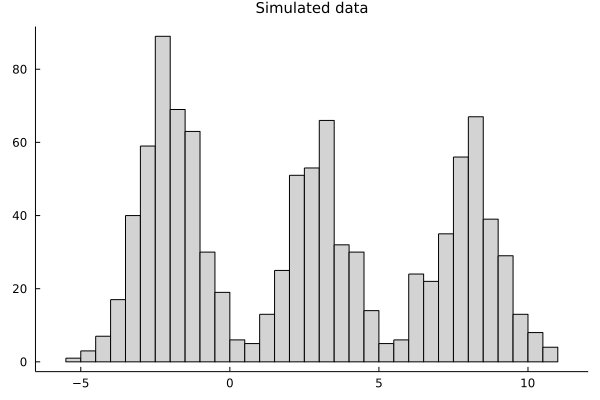

In [71]:
# parameters
mu = [-2, 3, 8]
tau = 1
pi = [0.4, 0.3, 0.3]
N = 1000
K = length(mu)

# data simulation
Y = zeros(0)
for i in range(1, K)
    append!(Y, rand(Normal(mu[i], 1/tau), Int(N * pi[i])))
end

histogram(Y, bins = 40, title="Simulated data")

In [30]:
Mu, Pi, K = reversible_jump(
    Y, 
    max_K=4,
    mu0=0.0, 
    pi0=1.0, 
    tau0=1.0, 
    tau=1.0, 
    prior_mu=Normal(0,10)
);

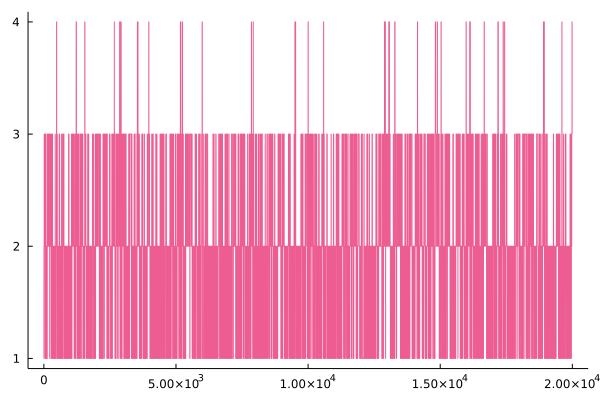

In [68]:
plot(K, color=7)

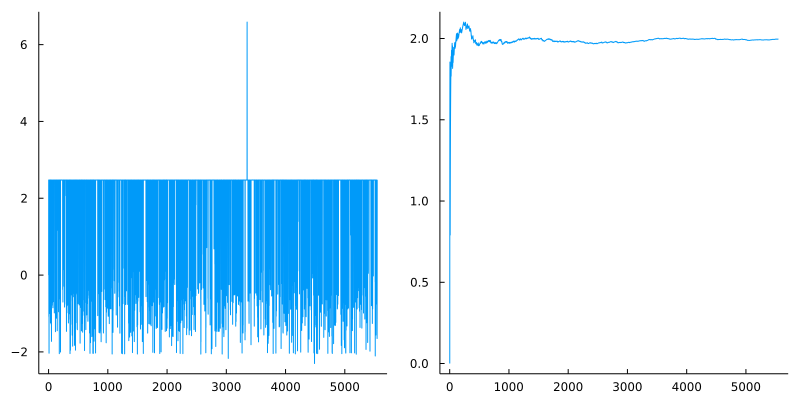

In [48]:
plot_estimates(Mu, 1)

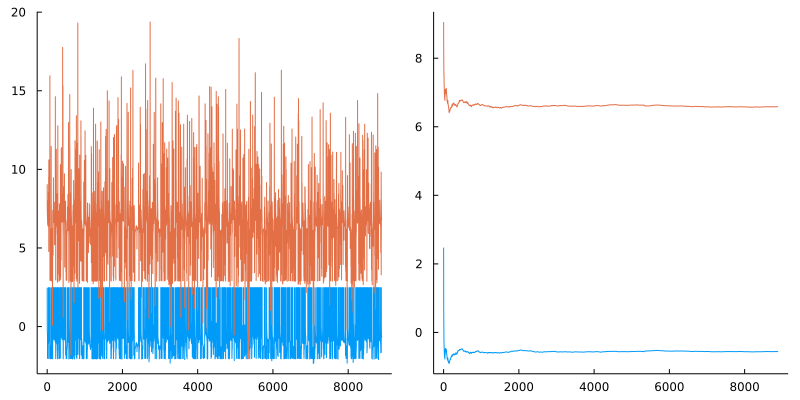

In [49]:
plot_estimates(Mu, 2)

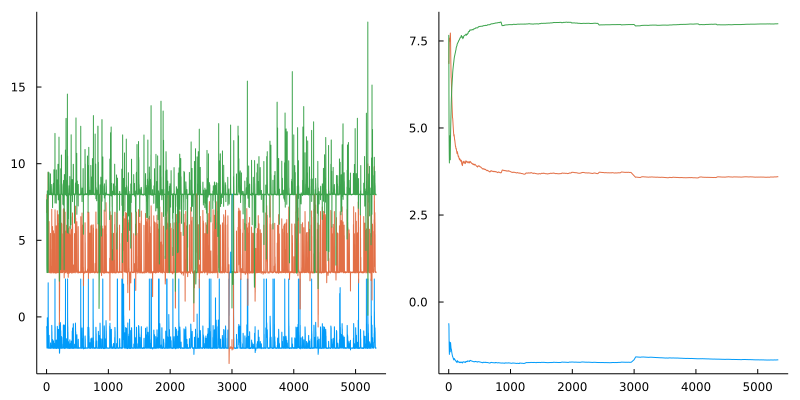

In [50]:
plot_estimates(Mu, 3)

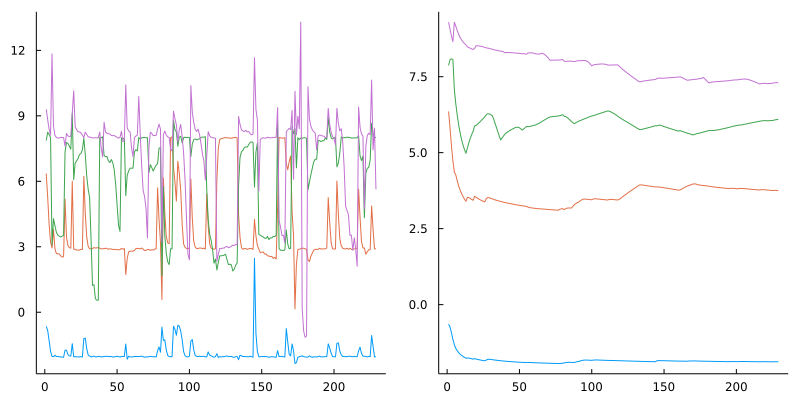

In [51]:
plot_estimates(Mu, 4)

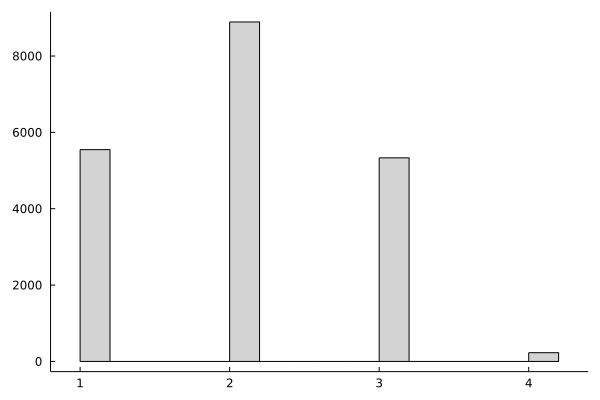

In [70]:
histogram(K)